## 0. Importing the necessary libraries and loading in data

In [230]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import defaultdict
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [231]:
#Loading in the data using pandas to read the parquet file
TY_users = pd.read_parquet("/Users/wendyessilfie/Documents/GitHub/Business-statistics-/TaoYin_User_Transactions_v2.parquet")

## 1. Feature enginering by customers

#### 1.1. Creating new feature of customer by profit and sales

In [232]:
# Calculate the 'profit' column using the formula (sum2 - sum1)
TY_users.loc[:,"profit"] = (TY_users["sum2"] - TY_users["sum1"])
TY_users.head()

,customer,invoice,invoice_date,articlenr,volume,sum1,sum2,postcode_delivery,postcode_customer,channel,profit
0,2284,1187467,2020-01-02,32879960,24,343.73,362.30,80413,80413,Tel 86041,18.57
1,2284,1187467,2020-01-02,32879962,60,1067.64,1119.96,80413,80413,Tel 86041,52.32
2,2284,1187467,2020-01-02,32841810,120,2214.00,2408.40,80413,80413,Tel 86041,194.40
3,1704,1191447,2020-01-17,36866802,1,21.52,19.32,81724,81724,OTC 81812,-2.20
4,45,1187691,2020-01-03,34360272,4,28.91,28.49,81796,81796,Web Order,-0.42


In [233]:
# Grouping the dataset by customers and aggregating on profit
TY_customer_merged = TY_users.groupby("customer").agg({'profit' : ['sum'], 'sum2' : ['sum']}).reset_index()
TY_customer_merged.head(10)

# Flatten the column index
TY_customer_merged.columns = ['_'.join(col).strip() for col in TY_customer_merged.columns.values]

# Rename sales column
TY_customer_merged = TY_customer_merged.rename(columns={'sum2_sum': 'sales_sum'})

# Display the DataFrame
print(TY_customer_merged.head(10))

   customer_  profit_sum   sales_sum
0          0       -2.53       13.72
1          3    10263.09   712214.87
2          4     -736.60     3135.02
3          5    -2220.25     2199.45
4          6       -8.89       99.48
5         14    33219.18  1397887.79
6         17    -1381.80      205.80
7         21       35.63      294.17
8         22     -126.29     1048.19
9         30       -8.49      289.87


In [234]:
# Total sum of 'profit' and 'sales'
column_sum1 = TY_customer_merged['profit_sum'].sum()
column_sum2 = TY_customer_merged['sales_sum'].sum()
print("Sum of Profit:", int(column_sum1))
print("Sum of Sales:", int(column_sum2))

Sum of Profit: 13312202
Sum of Sales: 127824304


##### * Intermediate conclusion 1.1.1 The company is profitable with a margin of ~10%

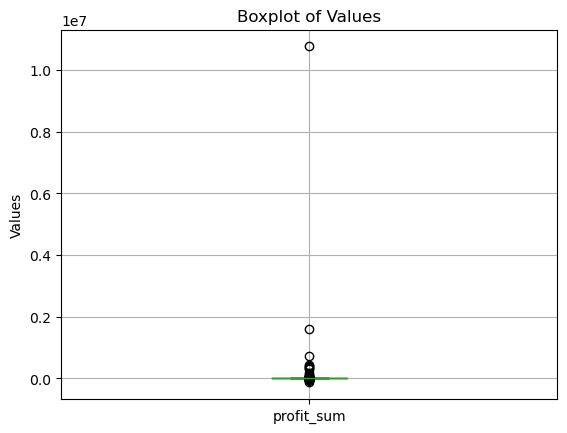

In [235]:
# Plotting the 'profit_sum' to view the distribution
TY_customer_merged.boxplot(column='profit_sum')

# Labeling the axes
plt.title('Boxplot of Values')
plt.ylabel('Values')

# Show the plot
plt.show()

#### * Intermediate conclusion 1.1.2. There are outliers which will distort my analysis. I need to take care of these outliers. 

In [236]:
# Extract the outliers
median = TY_customer_merged['sales_sum'].median()
mad = (TY_customer_merged['sales_sum'] - median).abs().median()

# calculate modified z-scores
TY_customer_merged['Sales Z-Score'] = 0.6745 * (TY_customer_merged['sales_sum'] - median) / mad

# identify outliers
outliers = TY_customer_merged[TY_customer_merged['Sales Z-Score'].abs() > 3.5]

# get a list of customer ids that are outliers
outlier_customers = outliers['customer_'].tolist()

#print list of outliers
print("Outliers using Z-score:")
print(outliers)

Outliers using Z-score:
      customer_  profit_sum   sales_sum  Sales Z-Score
1             3    10263.09   712214.87     181.743898
5            14    33219.18  1397887.79     357.392539
10           34       82.02    82857.65      20.521635
12           40    -2287.33    19653.09       4.330540
14           42    -2465.45   104423.75      26.046217
...         ...         ...         ...            ...
1052       2459   -13676.74    69836.86      17.186103
1060       2478    23093.03   149798.85      37.669943
1062       2486     6255.48    33897.85       7.979616
1064       2488     5513.15   224654.12      56.845597
1069       2500   -13025.00    50832.34      12.317720

[249 rows x 4 columns]


In [237]:
# Check if there are any infinite values in the margins_sum column
print(TY_customer_merged['profit_sum'].isin([np.inf, -np.inf]).sum())

# Replace infinite values with NaN
TY_customer_merged['profit_sum'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Optionally, fill NaN values with the maximum of the non-infinite data
TY_customer_merged['profit_sum'].fillna(TY_customer_merged['profit_sum'].max(), inplace=True)

0


/var/folders/fh/wbkbplv94qz11z3b8wk1mrmw0000gn/T/ipykernel_4016/1104076654.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  TY_customer_merged['profit_sum'].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/fh/wbkbplv94qz11z3b8wk1mrmw0000gn/T/ipykernel_4016/1104076654.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on w

In [238]:
# Determine the min and max values of 'profit_sum' to create bins without the outliers
filtered_df = TY_customer_merged[~TY_customer_merged['customer_'].isin(outlier_customers)]
min_profit = filtered_df['profit_sum'].min()
max_profit = filtered_df['profit_sum'].max()

# Create evenly spaced bins for margins using min and max values
bins = np.linspace(min_profit, max_profit, num=6)  # Creates 5 equal-width intervals
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Create profit categories based on these equal-width bins
TY_customer_merged['profit_category'] = pd.cut(TY_customer_merged['profit_sum'], bins=bins, labels=labels, include_lowest=True)
TY_customer_merged.loc[TY_customer_merged['profit_sum'] > max_profit, 'profit_category'] = 'Very High' # bring the outliers back
TY_customer_merged.loc[TY_customer_merged['profit_sum'] < min_profit, 'profit_category'] = 'Very Low'  # bring the outliers back

# Sort by margin category and volume
sorted_df = TY_customer_merged.sort_values(by=['profit_category', 'sales_sum'], ascending=[True, False]).reset_index()

# Display the sorted dataframe
#print(sorted_df[['customer_', 'profit_sum', 'sales_sum', 'profit_category']].head(20))
sorted_df['profit_category'].value_counts()

profit_category
Medium       695
Low          195
Very Low     132
Very High     39
High           9
Name: count, dtype: int64

In [239]:
TY_customer_merged.head()

,customer_,profit_sum,sales_sum,Sales Z-Score,profit_category
0,0,-2.53,13.72,-0.700472,Medium
1,3,10263.09,712214.87,181.743898,Very High
2,4,-736.60,3135.02,0.099111,Medium
3,5,-2220.25,2199.45,-0.140554,Low
4,6,-8.89,99.48,-0.678503,Medium


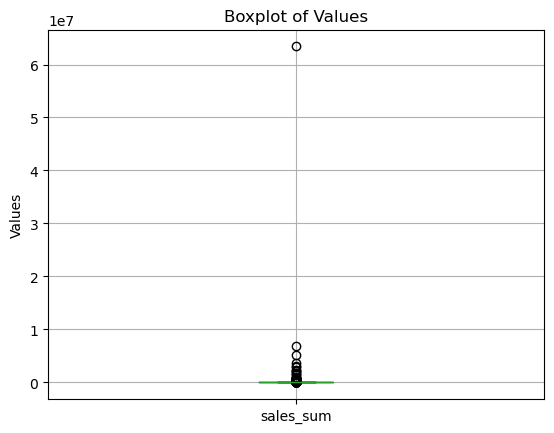

In [240]:
TY_customer_merged.boxplot(column='sales_sum')

# Labeling the axes
plt.title('Boxplot of Values')
plt.ylabel('Values')

# Show the plot
plt.show()

In [241]:
# Extract the outliers
median = TY_customer_merged['sales_sum'].median()
mad = (TY_customer_merged['sales_sum'] - median).abs().median()

# calculate modified z-scores
TY_customer_merged['Sales Z-Score'] = 0.6745 * (TY_customer_merged['sales_sum'] - median) / mad

# identify outliers
outliers = TY_customer_merged[TY_customer_merged['Sales Z-Score'].abs() > 3.5]

# get a list of customer ids that are outliers
outlier_customers = outliers['customer_'].tolist()

#print list of outliers
print("Outliers using Z-score:")
print(outliers)

Outliers using Z-score:
      customer_  profit_sum   sales_sum  Sales Z-Score profit_category
1             3    10263.09   712214.87     181.743898       Very High
5            14    33219.18  1397887.79     357.392539       Very High
10           34       82.02    82857.65      20.521635          Medium
12           40    -2287.33    19653.09       4.330540             Low
14           42    -2465.45   104423.75      26.046217             Low
...         ...         ...         ...            ...             ...
1052       2459   -13676.74    69836.86      17.186103        Very Low
1060       2478    23093.03   149798.85      37.669943       Very High
1062       2486     6255.48    33897.85       7.979616       Very High
1064       2488     5513.15   224654.12      56.845597       Very High
1069       2500   -13025.00    50832.34      12.317720        Very Low

[249 rows x 5 columns]


In [242]:
# Check if there are any infinite values in the margins_sum column
print(TY_customer_merged['sales_sum'].isin([np.inf, -np.inf]).sum())

# Replace infinite values with NaN
TY_customer_merged['sales_sum'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Optionally, fill NaN values with the maximum of the non-infinite data
TY_customer_merged['sales_sum'].fillna(TY_customer_merged['sales_sum'].max(), inplace=True)

0


/var/folders/fh/wbkbplv94qz11z3b8wk1mrmw0000gn/T/ipykernel_4016/3231130721.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  TY_customer_merged['sales_sum'].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/fh/wbkbplv94qz11z3b8wk1mrmw0000gn/T/ipykernel_4016/3231130721.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on wh

In [243]:
TY_customer_merged.head()

,customer_,profit_sum,sales_sum,Sales Z-Score,profit_category
0,0,-2.53,13.72,-0.700472,Medium
1,3,10263.09,712214.87,181.743898,Very High
2,4,-736.60,3135.02,0.099111,Medium
3,5,-2220.25,2199.45,-0.140554,Low
4,6,-8.89,99.48,-0.678503,Medium


In [244]:
# Determine the min and max values of 'profit_sum' to create bins without the outliers
filtered_df = TY_customer_merged[~TY_customer_merged['customer_'].isin(outlier_customers)]
min_profit = filtered_df['sales_sum'].min()
max_profit = filtered_df['sales_sum'].max()

# Create evenly spaced bins for sales using min and max values
bins = np.linspace(min_profit, max_profit, num=6)  # Creates 5 equal-width intervals
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# Create profit categories based on these equal-width bins
TY_customer_merged['sales_category'] = pd.cut(TY_customer_merged['sales_sum'], bins=bins, labels=labels, include_lowest=True)
TY_customer_merged.loc[TY_customer_merged['sales_sum'] > max_profit, 'sales_category'] = 'Very High' # bring the outliers back
TY_customer_merged.loc[TY_customer_merged['sales_sum'] < min_profit, 'sales_category'] = 'Very Low'  # bring the outliers back

# Sort by sales category and volume
sorted_df = TY_customer_merged.sort_values(by=['sales_category', 'sales_sum'], ascending=[True, False]).reset_index()

# Display the sorted dataframe
sorted_df['sales_category'].value_counts()
print(sorted_df[['customer_', 'profit_sum','profit_category','sales_sum', 'sales_category']].head(20))


    customer_  profit_sum profit_category  sales_sum sales_category
0        2473     -489.40          Medium    3272.79       Very Low
1        2133     -909.83             Low    3256.96       Very Low
2        1763     -395.94          Medium    3243.55       Very Low
3        1887    -4207.50        Very Low    3230.00       Very Low
4        2040     -445.39          Medium    3223.08       Very Low
5        2377       21.06          Medium    3217.90       Very Low
6         788     -211.76          Medium    3213.54       Very Low
7        1558    -1061.22             Low    3178.84       Very Low
8         287      240.07          Medium    3165.09       Very Low
9        2209      153.01          Medium    3160.30       Very Low
10        811    -1221.84             Low    3153.63       Very Low
11       1294       25.52          Medium    3148.57       Very Low
12          4     -736.60          Medium    3135.02       Very Low
13       1384     -976.54             Low    311

In [245]:
# create new dataframe to one hot encode profit and sales columns
customers_features = TY_customer_merged[['customer_', 'profit_category', 'sales_category']].copy()

# one-hot encode profit and sales columns
customers_features = pd.get_dummies(customers_features, columns=['profit_category', 'sales_category'], prefix=['profit', 'sales'])

# convert boolean values to binary
customers_features = customers_features.astype(int)

# convert column names to lowercase and add underscore between words
customers_features.columns = customers_features.columns.str.replace(' ', '_').str.lower()

# print df head
customers_features.head()

,customer_,profit_very_low,profit_low,profit_medium,profit_high,profit_very_high,sales_very_low,sales_low,sales_medium,sales_high,sales_very_high
0,0,0,0,1,0,0,1,0,0,0,0
1,3,0,0,0,0,1,0,0,0,0,1
2,4,0,0,1,0,0,1,0,0,0,0
3,5,0,1,0,0,0,1,0,0,0,0
4,6,0,0,1,0,0,1,0,0,0,0


#### 1.2. Creating new feature of customer by volume

In [246]:
# Group by 'customer' and calculate the sum of volumes for each customer
volume_sum_df = TY_users.groupby('customer').agg(volume_sum=('volume', 'sum'),).reset_index()     # Sum of volumes for each customer 

# Add a new column for the log of volume_sum
# Using np.log1p to handle cases where volume_sum might be zero
volume_sum_df['log_volume_sum'] = np.log1p(volume_sum_df['volume_sum'])

# Display the resulting dataframe with the log-transformed column
volume_sum_df

,customer,volume_sum,log_volume_sum
0,0,1,0.693147
1,3,293321,12.589026
2,4,1315,7.182352
3,5,161,5.087596
4,6,3,1.386294
...,...,...,...
1065,2491,342,5.837730
1066,2492,3634,8.198364
1067,2493,84,4.442651
1068,2496,117,4.770685


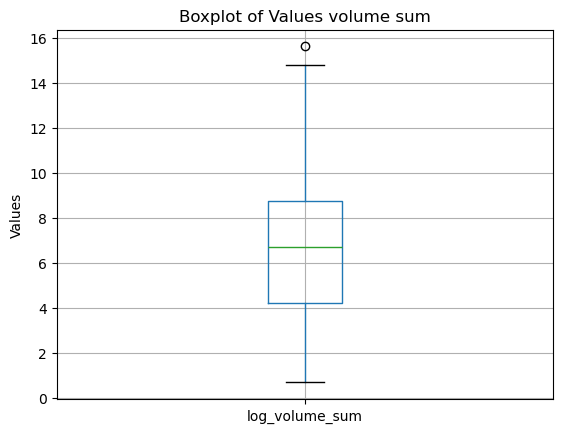

In [247]:
# Plotting the data for 'volume_sum' in a boxplot
volume_sum_df.boxplot(column='log_volume_sum')

# Labeling the axes
plt.title('Boxplot of Values volume sum')
plt.ylabel('Values')

# Show the plot
plt.show()

In [248]:
# Create 5 bins based on the log-transformed data
volume_sum_df['volume_category'] = pd.cut(volume_sum_df['log_volume_sum'],   # The log-transformed volume data
bins=5,                                                                      # Number of bins
labels=["Very Low", "Low", "Medium", "High", "Very High"])

# Display the resulting dataframe with volume categories
print(volume_sum_df[['customer', 'volume_sum', 'log_volume_sum', 'volume_category']])

      customer  volume_sum  log_volume_sum volume_category
0            0           1        0.693147        Very Low
1            3      293321       12.589026            High
2            4        1315        7.182352          Medium
3            5         161        5.087596             Low
4            6           3        1.386294        Very Low
...        ...         ...             ...             ...
1065      2491         342        5.837730             Low
1066      2492        3634        8.198364          Medium
1067      2493          84        4.442651             Low
1068      2496         117        4.770685             Low
1069      2500       27348       10.216435            High

[1070 rows x 4 columns]


In [249]:
# Counting the customers in the categories
volume_sum_df['volume_category'].value_counts()

volume_category
Medium       362
Low          303
Very Low     228
High         159
Very High     18
Name: count, dtype: int64

In [250]:
# Creating df_volume with only necessary colums
df_volume = volume_sum_df[['customer', 'volume_category']]
df_volume

,customer,volume_category
0,0,Very Low
1,3,High
2,4,Medium
3,5,Low
4,6,Very Low
...,...,...
1065,2491,Low
1066,2492,Medium
1067,2493,Low
1068,2496,Low


In [251]:
# Create a new dataframe and one-hot encode the 'volume_category' column
df_volume_encoded = pd.get_dummies(df_volume, columns=['volume_category'], prefix='volume')

# Convert boolean values to binary (just in case any boolean data is present)
df_volume_encoded = df_volume_encoded.astype(int)

# Convert column names to lowercase and replace spaces with underscores
df_volume_encoded.columns = df_volume_encoded.columns.str.replace(' ', '_').str.lower()

# Display the first few rows of the dataframe
df_volume_encoded


,customer,volume_very_low,volume_low,volume_medium,volume_high,volume_very_high
0,0,1,0,0,0,0
1,3,0,0,0,1,0
2,4,0,0,1,0,0
3,5,0,1,0,0,0
4,6,1,0,0,0,0
...,...,...,...,...,...,...
1065,2491,0,1,0,0,0
1066,2492,0,0,1,0,0
1067,2493,0,1,0,0,0
1068,2496,0,1,0,0,0


#### 1.3. Creating new feature of customer by discount

In [252]:
# Create a new dataframe with only the necessary columns from the original dataframe
df_discount = TY_users[['customer', 'articlenr', 'sum1', 'sum2']].copy()

# Determine if there was a discount: giving a 1 if sum2 (paid) is less than sum1 (original), otherwise 0
df_discount['discount'] = df_discount.apply(lambda row: 1 if row['sum2'] < row['sum1'] else 0, axis=1)

# Calculate the discount rate as a percentage if there was a discount
df_discount['discount_rate'] = df_discount.apply(lambda row: ((row['sum1'] - row['sum2']) / row['sum1'] * 100) if row['discount'] == 1 else 0,axis=1)

# Group by 'customer' and aggregate and including discount frequency
df_discount = df_discount.groupby('customer').agg(
    artikelnr=('articlenr', 'first'),                 # Keep the first artikelnr per customer
    discount=('discount', 'sum'),                     # Number of discounted transactions
    discount_rate=('discount_rate', 'mean'),          # Average discount rate per customer
    discount_perc=('discount', 'mean')           # Frequency of discount as a percentage of total transactions
).reset_index()

# Display the resulting DataFrame
df_discount.head()

,customer,artikelnr,discount,discount_rate,discount_perc
0,0,34575542,1,15.569231,1.000000
1,3,34390038,1558,11.041620,0.640625
2,4,35803822,103,22.312268,0.944954
3,5,28476112,31,30.569566,0.939394
4,6,35606348,3,7.843936,1.000000


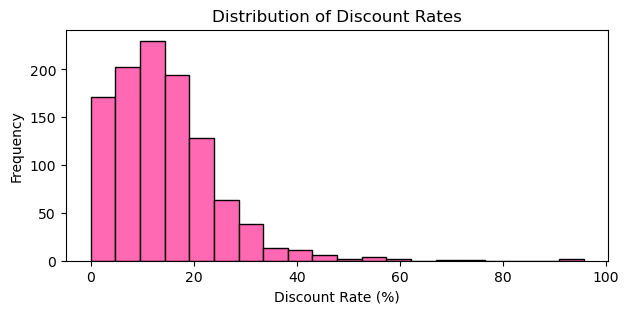

In [253]:
# Ploting a histogram of the discount rates
plt.figure(figsize=(7, 3))
plt.hist(df_discount['discount_rate'], bins=20, edgecolor='black', color='hotpink')
plt.xlabel('Discount Rate (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Discount Rates')
plt.show()

In [254]:
# Define customed categorize and labels 
category = [0, 0.01, 10, 20, 30, float('inf')]                 # Bins are based on a business logic
names = ['No Discount', 'Low Discount', 'Medium Discount', 'High Discount', 'Very High Discount']

# Using pd.cut to categorize 'discount_rate' into the defined bins
df_discount['discount_rate_category'] = pd.cut(df_discount['discount_rate'], bins=category, labels=names, right=False)

# Display the resulting DataFrame
df_discount.head()

,customer,artikelnr,discount,discount_rate,discount_perc,discount_rate_category
0,0,34575542,1,15.569231,1.000000,Medium Discount
1,3,34390038,1558,11.041620,0.640625,Medium Discount
2,4,35803822,103,22.312268,0.944954,High Discount
3,5,28476112,31,30.569566,0.939394,Very High Discount
4,6,35606348,3,7.843936,1.000000,Low Discount


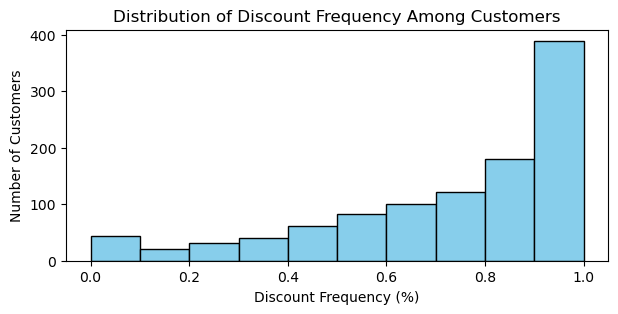

In [255]:
# Plot a histogram of the discount frequency
plt.figure(figsize=(7, 3))
plt.hist(df_discount['discount_perc'], bins=10, edgecolor='black', color='skyblue')
plt.xlabel('Discount Frequency (%)')
plt.ylabel('Number of Customers')
plt.title('Distribution of Discount Frequency Among Customers')
plt.show()

In [256]:
# Defining custom category and labels for discount frequency 
category = [0, 0.10, 0.30, 0.50, 0.80, 1]  # Bins up to 1 included
names = ['No Discount', 'Low ', 'Medium ', 'High ', 'Very High ']

# Use pd.cut to categorize 'discount_frequency' into defined categories
df_discount['discount_%_category'] = pd.cut(df_discount['discount_perc'], bins=category, labels=names, right=True)

# Display the resulting DataFrame
df_discount.head()

,customer,artikelnr,discount,discount_rate,discount_perc,discount_rate_category,discount_%_category
0,0,34575542,1,15.569231,1.000000,Medium Discount,Very High
1,3,34390038,1558,11.041620,0.640625,Medium Discount,High
2,4,35803822,103,22.312268,0.944954,High Discount,Very High
3,5,28476112,31,30.569566,0.939394,Very High Discount,Very High
4,6,35606348,3,7.843936,1.000000,Low Discount,Very High


In [257]:
# Displaying counted customers over the caterories
df_discount['discount_%_category'].value_counts()

discount_%_category
Very High      558
High           285
Medium         131
Low             52
No Discount      6
Name: count, dtype: int64

In [258]:
# Select only the customer and discount_freq_category columns
df_discount_category = df_discount[['customer', 'discount_%_category', 'discount_rate_category']]

# Display the resulting dataframe
df_discount_category.head()


,customer,discount_%_category,discount_rate_category
0,0,Very High,Medium Discount
1,3,High,Medium Discount
2,4,Very High,High Discount
3,5,Very High,Very High Discount
4,6,Very High,Low Discount


In [259]:
# One-hot encode the 'discount_freq_category' and 'discount_rate_category' columns
df_discount_encoded = pd.get_dummies(df_discount_category, columns=['discount_%_category', 'discount_rate_category'], prefix=['freq', 'rate'])

# Convert boolean values to binary (if any are present)
df_discount_encoded = df_discount_encoded.astype(int)

# Convert column names to lowercase and replace spaces with underscores
df_discount_encoded.columns = df_discount_encoded.columns.str.replace(' ', '_').str.lower()

# Display the first few rows of the resulting dataframe
df_discount_encoded.head()


,customer,freq_no_discount,freq_low_,freq_medium_,freq_high_,freq_very_high_,rate_no_discount,rate_low_discount,rate_medium_discount,rate_high_discount,rate_very_high_discount
0,0,0,0,0,0,1,0,0,1,0,0
1,3,0,0,0,1,0,0,0,1,0,0
2,4,0,0,0,0,1,0,0,0,1,0
3,5,0,0,0,0,1,0,0,0,0,1
4,6,0,0,0,0,1,0,1,0,0,0


#### 1.4. Creating new feature of customer by purchase recency and frequency

In [260]:
# Calculate purchase frequency for each customer
purchase_frequency = TY_users.groupby('customer')['invoice'].nunique()
purchase_frequency = purchase_frequency.rename("purchase_frequency")                     # Add a name to the Series

# View the purchase frequency as dataframe
purchase_frequency_df = purchase_frequency.reset_index()
purchase_frequency_df.head()

,customer,purchase_frequency
0,0,1
1,3,529
2,4,39
3,5,5
4,6,2


In [261]:
# Changing'invoice_date' to datetime format
TY_users['invoice_date'] = pd.to_datetime(TY_users['invoice_date'])

# Calculate the latest date and days since last purchase for each customer
latest_date = TY_users['invoice_date'].max()
days_since_last_purchase_df = (latest_date - TY_users.groupby('customer')['invoice_date'].max()).dt.days.reset_index()

# Rename the column for readability
days_since_last_purchase_df.columns= ['customer', 'days_since_last_purchase']

# Display the resulting DataFrame
days_since_last_purchase_df.head()

,customer,days_since_last_purchase
0,0,1450
1,3,6
2,4,145
3,5,1664
4,6,1181


#### 1.5. Creating a new feature by clustering customers by postcode

1.5.1 Clustering using K-means

In [262]:
# group customers by postcode while counting the number of customers in each postcode
customers_by_postcode = TY_users.groupby('postcode_customer')['customer'].nunique().reset_index()

# rename column
customers_by_postcode.columns = ['postcode_customer','customer_count']

# sort by customer count
customers_by_postcode_sorted = customers_by_postcode.sort_values(by='customer_count', ascending=False)

# print result
print(customers_by_postcode_sorted.head(20))

     postcode_customer  customer_count
366              85705              27
477              87547              21
549              89206              18
74               81704              12
550              89207              12
393              86041              11
108              81812              10
69               81689               9
544              89201               9
178              83047               8
458              87500               8
266              84817               7
90               81747               7
560              89247               7
394              86042               7
456              87482               6
398              86049               6
73               81703               6
114              81822               6
475              87545               6


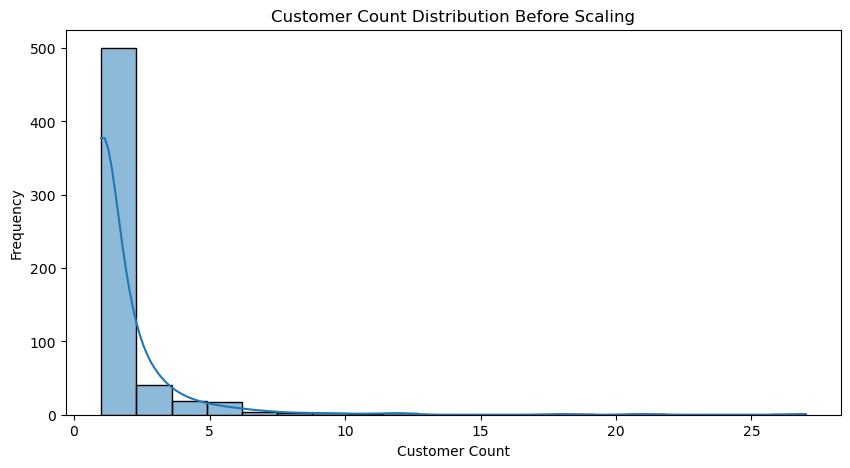

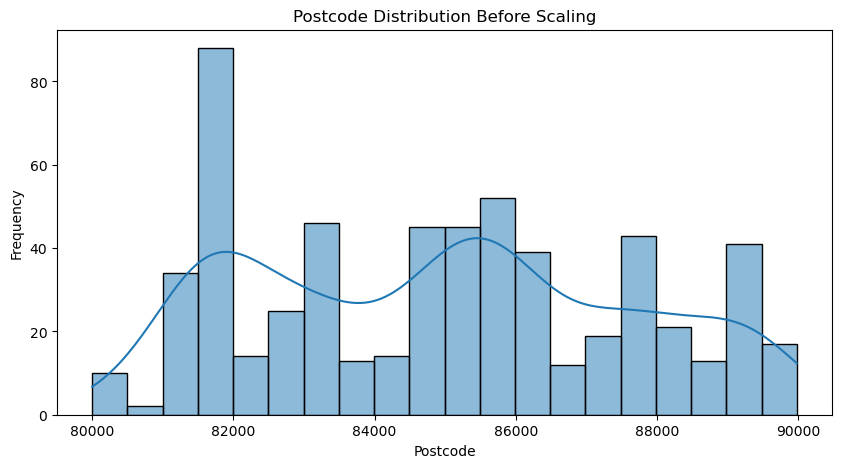

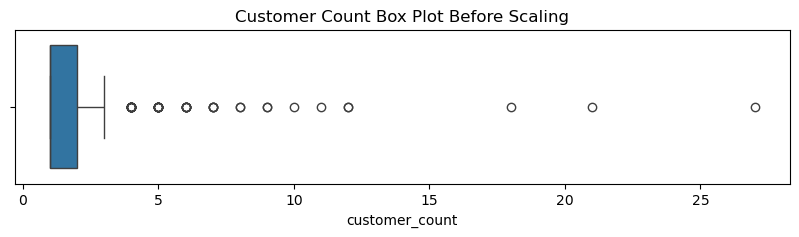

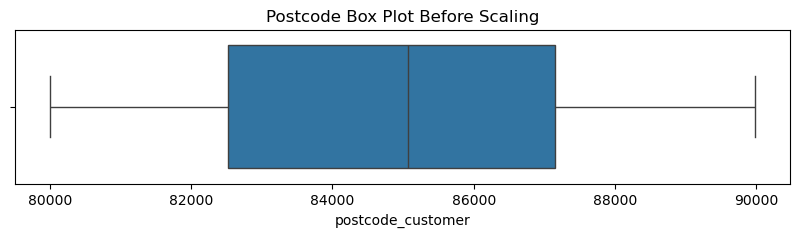

In [263]:
# Histogram for customer count before scaling
plt.figure(figsize=(10, 5))
sns.histplot(customers_by_postcode['customer_count'], bins=20, kde=True)
plt.title("Customer Count Distribution Before Scaling")
plt.xlabel("Customer Count")
plt.ylabel("Frequency")
plt.show()

# Histogram for postcode before scaling
plt.figure(figsize=(10, 5))
sns.histplot(customers_by_postcode['postcode_customer'], bins=20, kde=True)
plt.title("Postcode Distribution Before Scaling")
plt.xlabel("Postcode")
plt.ylabel("Frequency")
plt.show()

# Box plot for customer count before scaling
plt.figure(figsize=(10, 2))
sns.boxplot(x=customers_by_postcode['customer_count'])
plt.title("Customer Count Box Plot Before Scaling")
plt.show()

# Box plot for postcode before scaling
plt.figure(figsize=(10, 2))
sns.boxplot(x=customers_by_postcode['postcode_customer'])
plt.title("Postcode Box Plot Before Scaling")
plt.show()

In [264]:
# selecting features for k-means
X_kmeans = customers_by_postcode[['postcode_customer', 'customer_count']].values

In [265]:
# scaling & fit_transform the data 
scaler = StandardScaler()
X_scaled_kmeans = scaler.fit_transform(X_kmeans)

# Add scaled columns individually to the DataFrame
customers_by_postcode_scaled = customers_by_postcode.copy()
customers_by_postcode_scaled['postcode_scaled'] = X_scaled_kmeans[:, 0]  # Scaled postcode_customer
customers_by_postcode_scaled['customer_count_scaled'] = X_scaled_kmeans[:, 1]  # Scaled customer_count

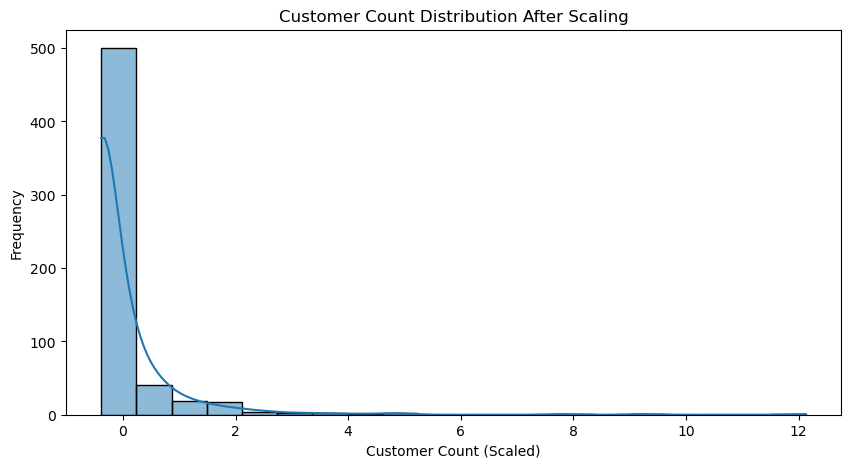

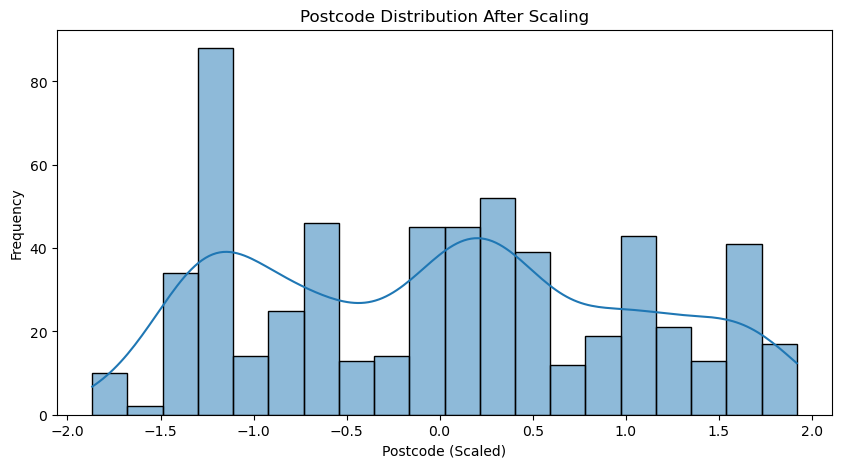

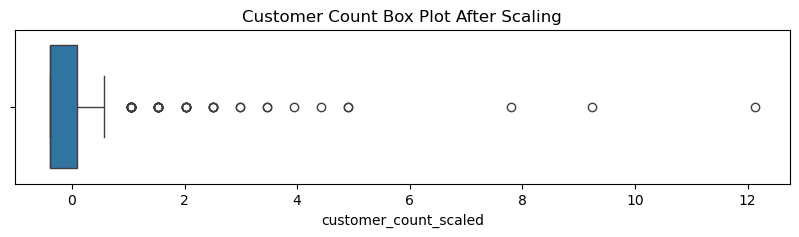

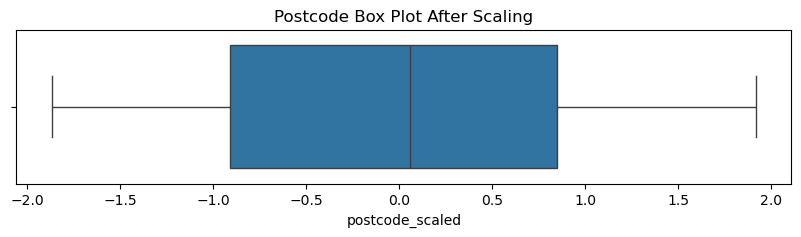

In [266]:
# Histogram to check customer_count distribution after scaling
plt.figure(figsize=(10, 5))
sns.histplot(customers_by_postcode_scaled['customer_count_scaled'], bins=20, kde=True)
plt.title("Customer Count Distribution After Scaling")
plt.xlabel("Customer Count (Scaled)")
plt.ylabel("Frequency")
plt.show()

# Histogram to check postcode distribution after scaling
plt.figure(figsize=(10, 5))
sns.histplot(customers_by_postcode_scaled['postcode_scaled'], bins=20, kde=True)
plt.title("Postcode Distribution After Scaling")
plt.xlabel("Postcode (Scaled)")
plt.ylabel("Frequency")
plt.show()

# Box plot for customer_count after scaling
plt.figure(figsize=(10, 2))
sns.boxplot(x=customers_by_postcode_scaled['customer_count_scaled'])
plt.title("Customer Count Box Plot After Scaling")
plt.show()

# Box plot for postcode after scaling
plt.figure(figsize=(10, 2))
sns.boxplot(x=customers_by_postcode_scaled['postcode_scaled'])
plt.title("Postcode Box Plot After Scaling")
plt.show()

In [267]:
# Check mean and standard deviation of the scaled data for customer count
mean_customer_count = customers_by_postcode_scaled['customer_count_scaled'].mean()  # should be close to 0
std_dev_customer_count = customers_by_postcode_scaled['customer_count_scaled'].std()  # should be close to 1

print(f"Mean after scaling for customer count: {mean_customer_count}")
print(f"Standard deviation after scaling for customer count: {std_dev_customer_count}")

# Check mean and standard deviation of the scaled data for postcode
mean_postcode = customers_by_postcode_scaled['postcode_scaled'].mean()  # should be close to 0
std_dev_postcode = customers_by_postcode_scaled['postcode_scaled'].std()  # should be close to 1

print(f"Mean after scaling for postcode: {mean_postcode}")
print(f"Standard deviation after scaling for postcode: {std_dev_postcode}")

Mean after scaling for customer count: -4.7928683693767295e-17
Standard deviation after scaling for customer count: 1.0008442382255016
Mean after scaling for postcode: 2.252648133607063e-15
Standard deviation after scaling for postcode: 1.000844238225504


Interpretation of results:

Because the mean is close to 0 and the standard deviation is very close to 1 for both features, it means that the data is correctly scaled and ready to cluster using K-means. 

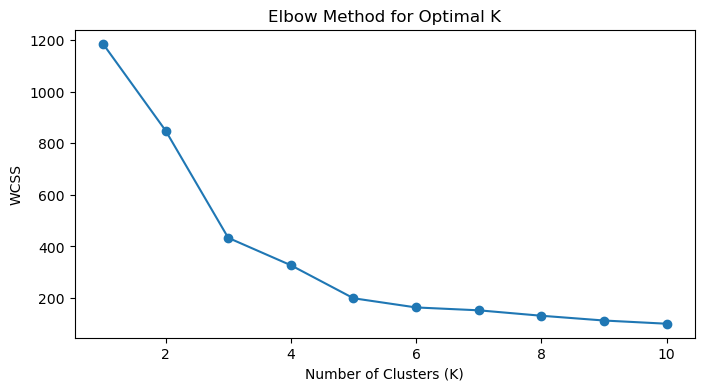

In [268]:
wcss = [] # empty list to store WCSS for each k-value

# test values 1-10 for K
for k in range (1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0) # setting the number of clusters
    kmeans.fit(X_scaled_kmeans) # fit k-means model
    wcss.append(kmeans.inertia_) # append wcss to list

# plot wcss values to find the elbow
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()

Applying K-means clustering with K=3

In [269]:
# Setting K to the chosen value
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
clusters = kmeans.fit_predict(X_scaled_kmeans)  # Fit and predict cluster labels

# Add cluster labels to your original DataFrame for analysis
customers_by_postcode['cluster_1'] = clusters

Applying K-means clustering with K=4

In [270]:
# Set K to the chosen value (e.g., 4 if the elbow suggests this)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
clusters = kmeans.fit_predict(X_scaled_kmeans)  # Fit and predict cluster labels

# Add cluster labels to your original DataFrame for analysis
customers_by_postcode['cluster_2'] = clusters

In [271]:
print("WCSS for K=3:", wcss[2])  # WCSS for 3 clusters
print("WCSS for K=4:", wcss[3])  # WCSS for 4 clusters

WCSS for K=3: 433.2224356599355
WCSS for K=4: 326.93654508385345


Based on the WCSS above, K=4 has better cohesion within the clusters.

Next, we will be calculating the silhouette score for K=3 and K=4 to compare which value provides better separation of data.

In [272]:
# fit KMeans for K=3
kmeans_3 = KMeans(n_clusters=3, random_state=42)
y_kmeans_3 = kmeans_3.fit_predict(X_scaled_kmeans) # fit and predict clusters

# fit KMeans for K=4
kmeans_4 = KMeans(n_clusters=4,random_state=42)
y_kmeans_4 = kmeans_4.fit_predict(X_scaled_kmeans) # fit & predict clusters

# calculate silhouette score for K=3
silhouette_score_3 = silhouette_score(X_scaled_kmeans, y_kmeans_3)
print(f'Silhouette score for K=3: {silhouette_score_3}')

# calculate silhouette score for K=4
silhouette_score_4 = silhouette_score(X_scaled_kmeans, y_kmeans_4)
print(f'Silhouette score for K=4: {silhouette_score_4}')

Silhouette score for K=3: 0.41468533726507434
Silhouette score for K=4: 0.483383038531568


Since both silhouette scores are quite low, we calculated the silhouette score for K in the range 5 to 10. The results start to fluctuate after K=5, by constantly decreasing and slightly increasing. This indicates that additional clusters may not provide improvements. Thus, K=5 is the optimal number of clusters.

In [273]:
# fit KMeans for K=5
kmeans_5 = KMeans(n_clusters=5, random_state=42)
y_kmeans_5 = kmeans_5.fit_predict(X_scaled_kmeans)  # fit & predict clusters

# calculate silhouette score for K=10
silhouette_score_5 = silhouette_score(X_scaled_kmeans, y_kmeans_5)
print(f'Silhouette score for K=5: {silhouette_score_5}')

Silhouette score for K=5: 0.512742010320806


In [274]:
customers_by_postcode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   postcode_customer  593 non-null    int64
 1   customer_count     593 non-null    int64
 2   cluster_1          593 non-null    int32
 3   cluster_2          593 non-null    int32
dtypes: int32(2), int64(2)
memory usage: 14.0 KB


In [275]:
# Dropping columns 'cluster_1' and 'cluster_2'
customers_by_postcode = customers_by_postcode.drop(columns=['cluster_1', 'cluster_2'])
customers_by_postcode.head()

,postcode_customer,customer_count
0,80000,1
1,80016,1
2,80023,1
3,80036,1
4,80085,1


In [276]:
# Adding cluster labels to the df for analysis
customers_by_postcode['cluster'] = clusters

# Summarizing the number of customers per cluster
cluster_summary = customers_by_postcode['cluster'].value_counts().sort_index()
print(cluster_summary)

cluster
0    215
1      9
2    217
3    152
Name: count, dtype: int64


In [277]:
# Get cluster centers
cluster_centers_k5 = kmeans_5.cluster_centers_

# Create DataFrame to view the cluster centers
cluster_centers_df = pd.DataFrame(cluster_centers_k5, columns=['customer_count', 'postcode_customer'])
print(cluster_centers_df)

   customer_count  postcode_customer
0        0.129619          -0.234838
1        1.321240          -0.196582
2       -1.090386          -0.178538
3        0.973159           9.717476
4        0.259941           2.066911


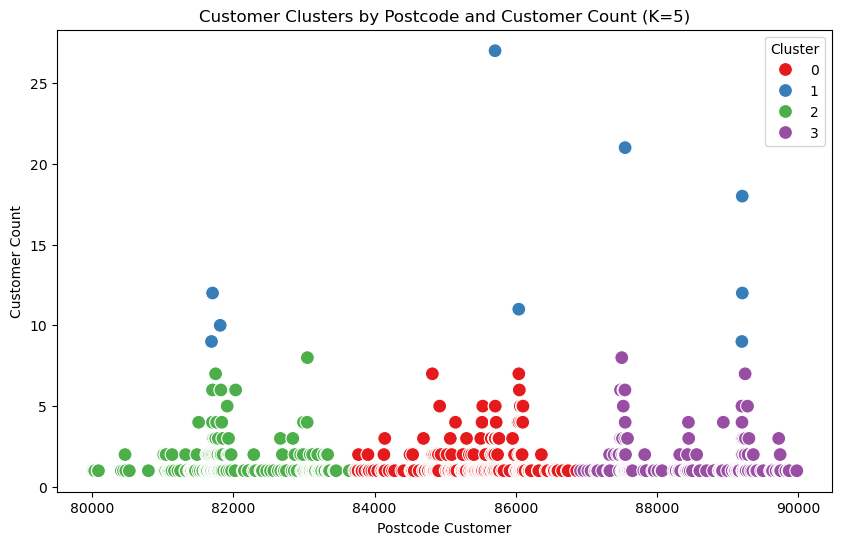

In [278]:
# Visualizing clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customers_by_postcode, x='postcode_customer', y='customer_count', hue='cluster', palette='Set1', marker='o', s=100)
plt.title('Customer Clusters by Postcode and Customer Count (K=5)')
plt.xlabel('Postcode Customer')
plt.ylabel('Customer Count')
plt.legend(title='Cluster', loc='upper right')
plt.show()

Based on the visualization, cluster 1 seems to represent outliers.

In [279]:
# Filter out the data for Cluster 1
cluster_1_data = customers_by_postcode[customers_by_postcode['cluster'] == 1]

# Get a statistical summary for Cluster 1
cluster_1_summary = cluster_1_data[['customer_count', 'postcode_customer']].describe()
print(cluster_1_summary) 

       customer_count  postcode_customer
count        9.000000           9.000000
mean        14.333333       85790.222222
std          6.284903        3306.720837
min          9.000000       81689.000000
25%         10.000000       81812.000000
50%         12.000000       86041.000000
75%         18.000000       89201.000000
max         27.000000       89207.000000


In [280]:
customers_by_postcode.head()

,postcode_customer,customer_count,cluster
0,80000,1,2
1,80016,1,2
2,80023,1,2
3,80036,1,2
4,80085,1,2


In [281]:
print(customers_by_postcode.columns)

Index(['postcode_customer', 'customer_count', 'cluster'], dtype='object')


In [282]:
# merging original users df on the postcode clusters
TY_users = TY_users.merge(customers_by_postcode[['postcode_customer', 'cluster']], left_on='postcode_customer', right_on='postcode_customer', how='left')

# renaming 'cluster' to 'postcode_cluster'
TY_users.rename(columns={'cluster': 'postcode_cluster'}, inplace=True)

# creating a new df with only the necessary columns
customer_cluster_data = TY_users[['customer', 'postcode_cluster']].copy()

# one-hot encoding the postcode clusters
customer_cluster_data = pd.get_dummies(customer_cluster_data, columns=['postcode_cluster'], prefix='postcode_cluster')

# coverting bool values to binary
customer_cluster_data = customer_cluster_data.astype(int)

In [283]:
customer_cluster_data.head()

,customer,postcode_cluster_0,postcode_cluster_1,postcode_cluster_2,postcode_cluster_3
0,2284,0,0,1,0
1,2284,0,0,1,0
2,2284,0,0,1,0
3,1704,0,0,1,0
4,45,0,0,1,0


In [284]:
TY_users.head(7)

,customer,invoice,invoice_date,articlenr,volume,sum1,sum2,postcode_delivery,postcode_customer,channel,profit,postcode_cluster
0,2284,1187467,2020-01-02,32879960,24,343.73,362.30,80413,80413,Tel 86041,18.57,2
1,2284,1187467,2020-01-02,32879962,60,1067.64,1119.96,80413,80413,Tel 86041,52.32,2
2,2284,1187467,2020-01-02,32841810,120,2214.00,2408.40,80413,80413,Tel 86041,194.40,2
3,1704,1191447,2020-01-17,36866802,1,21.52,19.32,81724,81724,OTC 81812,-2.20,2
4,45,1187691,2020-01-03,34360272,4,28.91,28.49,81796,81796,Web Order,-0.42,2
5,812,1187640,2020-01-03,35620322,1,119.91,125.73,81681,81681,Web Order,5.82,2
6,812,1187640,2020-01-03,35623298,1,346.06,350.60,81681,81681,Web Order,4.54,2


In [285]:
# one-hot encoding postcode clusters
customers_by_postcode = pd.get_dummies(customers_by_postcode, columns=['cluster'], prefix=['postcode'])

# convert boolean values to binary
customers_by_postcode = customers_by_postcode.astype(int)

# convert column names to lowercase and add underscore between words
customers_by_postcode.columns = customers_by_postcode.columns.str.replace(' ', '_').str.lower()

# print df head
customers_by_postcode.head()

,postcode_customer,customer_count,postcode_0,postcode_1,postcode_2,postcode_3
0,80000,1,0,0,1,0
1,80016,1,0,0,1,0
2,80023,1,0,0,1,0
3,80036,1,0,0,1,0
4,80085,1,0,0,1,0


#### 1.6. Creating new feature of customer by dropshippers

In [286]:
# ----- wendy -----
mismatched_postcode = TY_users[TY_users["postcode_delivery"] != TY_users["postcode_customer"]]
print(f"Number of mismatched row and columns: {mismatched_postcode.shape}")

Number of mismatched row and columns: (71089, 12)


In [287]:
# Identify customers where postcodes are the same (non-dropshippers)
same_postcode = TY_users['postcode_delivery'] == TY_users['postcode_customer']

# Identify customers with consistent mismatched postcodes (retailers)
consistent_mismatch = TY_users.groupby('customer').apply(lambda x: (x['postcode_delivery'].nunique() == 1) and (x['postcode_customer'].nunique() == 1) and (not same_postcode[x.index].all()))

# Step 3: Assign default category 'dropshipper' to all customers
TY_users['customer_type'] = 'dropshipper'

# Step 4: Update 'customer_type' for non-dropshippers and retailers
TY_users.loc[same_postcode, 'customer_type'] = 'non-dropshipper'
TY_users.loc[TY_users['customer'].isin(consistent_mismatch[consistent_mismatch].index), 'customer_type'] = 'warehouse'

# Step 5: Group by customer and get the first occurrence of each customer to create a grouped DataFrame
grouped_df = TY_users.groupby('customer').first().reset_index()

# Resulting grouped DataFrame
grouped_df.head()

/var/folders/fh/wbkbplv94qz11z3b8wk1mrmw0000gn/T/ipykernel_4016/4057607310.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  consistent_mismatch = TY_users.groupby('customer').apply(lambda x: (x['postcode_delivery'].nunique() == 1) and (x['postcode_customer'].nunique() == 1) and (not same_postcode[x.index].all()))


,customer,invoice,invoice_date,articlenr,volume,sum1,sum2,postcode_delivery,postcode_customer,channel,profit,postcode_cluster,customer_type
0,0,1258126,2020-10-06,34575542,1,16.25,13.72,81131,81131,Tel 81812,-2.53,2,non-dropshipper
1,3,1228666,2020-06-04,34390038,1,9.79,8.32,89207,89207,OTC 89206,-1.47,1,non-dropshipper
2,4,1418519,2022-07-12,35803822,1,43.02,34.57,89221,89221,OTC 89206,-8.45,3,non-dropshipper
3,5,1200226,2020-02-18,28476112,1,16.25,14.40,84849,84849,Tel 84817,-1.85,0,non-dropshipper
4,6,1327185,2021-07-02,35606348,1,53.39,48.52,89222,89222,OTC 89206,-4.87,3,non-dropshipper


In [288]:
# Checking what it looks like
grouped_df["customer_type"].value_counts()

customer_type
non-dropshipper    857
warehouse          154
dropshipper         59
Name: count, dtype: int64

In [289]:
# Filter grouped_df to include only rows where customer_type is 'dropshipper'
dropshipper = grouped_df[grouped_df['customer_type'] == 'dropshipper'].reindex()

# Display the resulting DataFrame with only drop shippers
dropshipper.head()

,customer,invoice,invoice_date,articlenr,volume,sum1,sum2,postcode_delivery,postcode_customer,channel,profit,postcode_cluster,customer_type
17,48,1230159,2020-06-09,28448816,50,122.55,193.90,83990,89301,Tel 89206,71.35,3,dropshipper
36,104,1203539,2020-02-28,37421648,2,10.24,10.64,83192,83194,Tel 83047,0.40,2,dropshipper
52,144,1197387,2020-02-06,26060570,50,96.38,110.74,89203,89206,OTC 89206,14.36,1,dropshipper
53,145,1243622,2020-07-31,36872130,1,28.95,27.87,86043,86049,OTC 86041,-1.08,0,dropshipper
58,156,1193214,2020-01-23,32202514,100,66.45,61.93,89230,89231,Tel 89206,-4.52,3,dropshipper


In [290]:
# Group by 'customer' and calculate total shipments, customer type, and total drop shipments only for drop shippers
tot_shipments_sum = TY_users.groupby('customer').agg(
tot_shipments=('customer', 'count'),                                # Total number of shipments per customer
customer_type=('customer_type', 'first'),                           # Consistent customer type for each customer
tot_dropshipments=('customer_type', lambda x: sum(x == 'dropshipper') if x.iloc[0] == 'dropshipper' else 0)).reset_index()

# Display the resulting DataFrame
tot_shipments_sum.head()


,customer,tot_shipments,customer_type,tot_dropshipments
0,0,1,non-dropshipper,0
1,3,2432,non-dropshipper,0
2,4,109,non-dropshipper,0
3,5,33,non-dropshipper,0
4,6,3,non-dropshipper,0


In [291]:
# Calculate the percentage of drop shipments for each customer
tot_shipments_sum["percentage_DS"] = (tot_shipments_sum["tot_dropshipments"] / tot_shipments_sum["tot_shipments"]) * 100

# Filter the DataFrame to show only rows where the customer type is 'dropshipper'
dropshipper_only = tot_shipments_sum[tot_shipments_sum["customer_type"] == "dropshipper"]

# Display the resulting DataFrame with only drop shippers
dropshipper_only.head()


,customer,tot_shipments,customer_type,tot_dropshipments,percentage_DS
17,48,21,dropshipper,21,100.000000
36,104,21,dropshipper,15,71.428571
52,144,576,dropshipper,387,67.187500
53,145,53,dropshipper,45,84.905660
58,156,259,dropshipper,200,77.220077


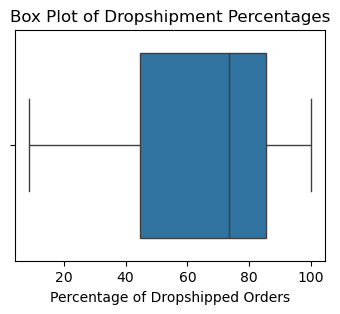

In [292]:
#plotting a boxplot to see what the distribution looks like
plt.figure(figsize=(4, 3))
sns.boxplot(x=dropshipper_only['percentage_DS'])
plt.title('Box Plot of Dropshipment Percentages')
plt.xlabel('Percentage of Dropshipped Orders')
plt.show()

In [293]:
# Create a copy of dropshipper_only to avoid warning
dropshipper_only = dropshipper_only.copy()

# Define categories and labels for categorizing 'percentage_DS'
categories = 5  # Number of equal-width intervals
names = ['Very low', 'Low', 'Medium', 'High', 'Very high']

# Create margin categories based on equal-width bins
dropshipper_only['category_dropshipping'] = pd.cut(dropshipper_only['percentage_DS'], bins=categories, labels=names)

# Sort by margin category (ascending)
sorted_dropshipments = dropshipper_only.sort_values(by='category_dropshipping', ascending=True)

# Display the sorted dataframe
sorted_dropshipments.head()

,customer,tot_shipments,customer_type,tot_dropshipments,percentage_DS,category_dropshipping
982,2298,16,dropshipper,2,12.500000,Very low
835,1979,91,dropshipper,10,10.989011,Very low
762,1823,1079,dropshipper,217,20.111214,Very low
135,347,154,dropshipper,27,17.532468,Very low
168,453,366,dropshipper,98,26.775956,Very low


In [294]:
# Create a copy of dropshipper_only to avoid warning
dropshipper_only = dropshipper_only.copy()

# Define categories and labels for categorizing 'percentage_DS'
categories = 5                                                  # Number of equal-width intervals
names = ['Very low', 'Low', 'Medium', 'High', 'Very high']

# Create categories based on equal-width bins
dropshipper_only['category_dropshipping'] = pd.cut(dropshipper_only['percentage_DS'], bins=categories, labels=names)

# Sort by category (ascending)
sorted_dropshipments = dropshipper_only.sort_values(by='category_dropshipping', ascending=True)

# Select only the customer and category_dropshipping columns
sorted_dropshipments = sorted_dropshipments[['customer', 'category_dropshipping']]

# Display the sorted dataframe
sorted_dropshipments.head()


,customer,category_dropshipping
982,2298,Very low
835,1979,Very low
762,1823,Very low
135,347,Very low
168,453,Very low


In [295]:
# One-hot encode the 'category_dropshipping' column
dropshipments_features = pd.get_dummies(sorted_dropshipments, columns=['category_dropshipping'], prefix='dropshipping')

# Convert boolean values to binary (if any are present)
dropshipments_features = dropshipments_features.astype(int)

# Convert column names to lowercase and replace spaces with underscores
dropshipments_features.columns = dropshipments_features.columns.str.replace(' ', '_').str.lower()

# Display the first few rows of the resulting dataframe
dropshipments_features.head()


,customer,dropshipping_very_low,dropshipping_low,dropshipping_medium,dropshipping_high,dropshipping_very_high
982,2298,1,0,0,0,0
835,1979,1,0,0,0,0
762,1823,1,0,0,0,0
135,347,1,0,0,0,0
168,453,1,0,0,0,0


## 2. Clustering the customers trough the new created features

#### 2.1. Merging the different engineered dataframes on customer

In [380]:
# Standardize the customer column name across all dataframes
dropshipments_features = dropshipments_features.rename(columns={'customer': 'customer'})
df_discount_encoded = df_discount_encoded.rename(columns={'customer': 'customer'})
df_volume_encoded = df_volume_encoded.rename(columns={'customer': 'customer'})
customers_features = customers_features.rename(columns={'customer_': 'customer'})  # Rename to match others
purchase_frequency_df = purchase_frequency_df.rename(columns={'customer': 'customer'})
days_since_last_purchase_df = days_since_last_purchase_df.rename(columns={'customer': 'customer'})

# Now merge all dataframes on the 'customer' column
merged_data = dropshipments_features.merge(df_discount_encoded, on='customer', how='outer') \
.merge(df_volume_encoded, on='customer', how='outer') \
.merge(customers_features, on='customer', how='outer') \
.merge(purchase_frequency_df, on='customer', how='outer') \
.merge(days_since_last_purchase_df, on='customer', how='outer')

# Fill NaN values with 0
merged_data = merged_data.fillna(0)

# Display the first few rows of the merged dataframe
merged_data.head()



,customer,dropshipping_very_low,dropshipping_low,dropshipping_medium,dropshipping_high,dropshipping_very_high,freq_no_discount,freq_low_,freq_medium_,freq_high_,...,profit_medium,profit_high,profit_very_high,sales_very_low,sales_low,sales_medium,sales_high,sales_very_high,purchase_frequency,days_since_last_purchase
0,0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,1450
1,3,0.0,0.0,0.0,0.0,0.0,0,0,0,1,...,0,0,1,0,0,0,0,1,529,6
2,4,0.0,0.0,0.0,0.0,0.0,0,0,0,0,...,1,0,0,1,0,0,0,0,39,145
3,5,0.0,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,5,1664
4,6,0.0,0.0,0.0,0.0,0.0,0,0,0,0,...,1,0,0,1,0,0,0,0,2,1181


#### 2.2. Clustering the customers to make meaningful insights

In [385]:
# Drop the 'customer' column
data_without_customer = merged_data.drop(columns=['customer'])
# Select only the columns to scale
columns_to_scale = ['purchase_frequency', 'days_since_last_purchase']
data_to_scale = data_without_customer[columns_to_scale]
# Define the StandardScaler instance
scaler = StandardScaler()
# Fit and transform only the selected columns
scaled_data = scaler.fit_transform(data_to_scale)
# Convert the scaled data to a DataFrame with the original column names
scaled_data_df = pd.DataFrame(scaled_data, columns=columns_to_scale)
# Combine the scaled columns with the rest of the DataFrame (excluding columns to scale)
df_final = data_without_customer.drop(columns=columns_to_scale).copy()  # Copy the unscaled columns
df_final[columns_to_scale] = scaled_data_df  # Add the scaled columns back
# Display the first few rows of the final DataFrame
df_final


,dropshipping_very_low,dropshipping_low,dropshipping_medium,dropshipping_high,dropshipping_very_high,freq_no_discount,freq_low_,freq_medium_,freq_high_,freq_very_high_,...,profit_medium,profit_high,profit_very_high,sales_very_low,sales_low,sales_medium,sales_high,sales_very_high,purchase_frequency,days_since_last_purchase
0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,-0.240232,1.688304
1,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,1.197067,-1.011283
2,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,-0.136790,-0.751419
3,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,-0.229343,2.088381
4,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,-0.237509,1.185403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,-0.199399,-0.998196
1066,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,-0.120457,-0.786940
1067,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,-0.232065,0.990973
1068,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,-0.221176,0.013214


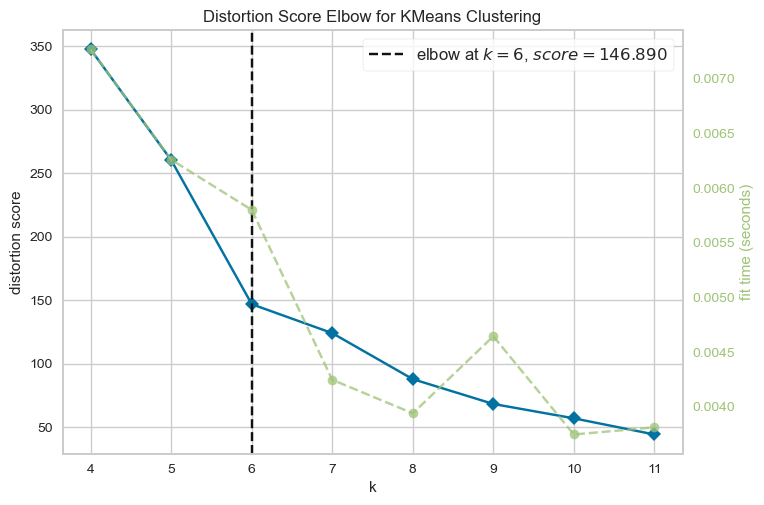

The best cluster number is: 6


In [392]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer  # Import KElbowVisualizer
# Define the features you want to use for clustering
most_important_features = ['purchase_frequency', 'days_since_last_purchase']
# Instantiate the clustering model
kmeans = KMeans(random_state=3092)
# Instantiate the Elbow visualizer
visualizer = KElbowVisualizer(kmeans, k=(4, 12))
# Fit the visualizer using only the specified important features
visualizer.fit(df_final[most_important_features])  # df_scaled should include the standardized data
visualizer.show()  # Display the elbow plot
# Print the optimal number of clusters (elbow value)
optimal_clusters = visualizer.elbow_value_
print('The best cluster number is:', optimal_clusters)



In [448]:
# Initialize the KMeans model with 6 clusters and fit it to the data
kmeans = KMeans(n_clusters=6, random_state=42)

# Fit the model and predict clusters using only the selected features
df_final['kmeans_cluster'] = kmeans.fit_predict(df_final[['purchase_frequency', 'days_since_last_purchase']])

# Display the first few rows of the DataFrame with the new cluster labels
df_final[['purchase_frequency', 'days_since_last_purchase', 'kmeans_cluster']]


,purchase_frequency,days_since_last_purchase,kmeans_cluster
0,-0.240232,1.688304,0
1,1.197067,-1.011283,1
2,-0.136790,-0.751419,5
3,-0.229343,2.088381,0
4,-0.237509,1.185403,0
...,...,...,...
1065,-0.199399,-0.998196,5
1066,-0.120457,-0.786940,5
1067,-0.232065,0.990973,0
1068,-0.221176,0.013214,3


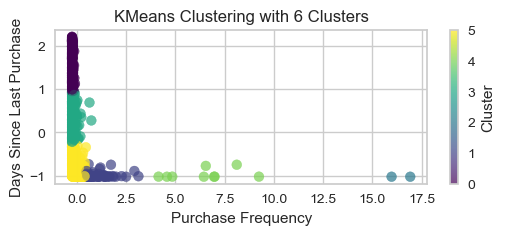

In [449]:
# Plot the clusters based on 'purchase_frequency' and 'days_since_last_purchase'
plt.figure(figsize=(6, 2))

# Scatter plot with color-coded clusters
scatter = plt.scatter(
df_final['purchase_frequency'], 
df_final['days_since_last_purchase'], 
c=df_final['kmeans_cluster'],                   # Color by cluster label
cmap='viridis', 
s=50, 
alpha=0.7)

# Add color bar to show cluster labels
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Purchase Frequency')
plt.ylabel('Days Since Last Purchase')
plt.title('KMeans Clustering with 6 Clusters')

plt.show()


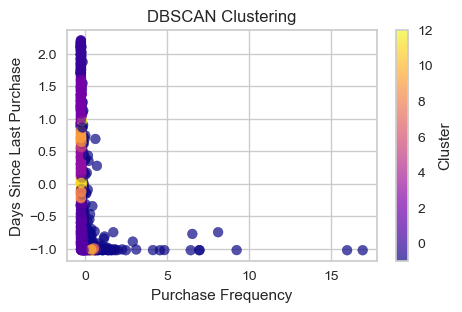

In [450]:
# Parameters for DBSCAN
# Initialize and fit DBSCAN
dbscan = DBSCAN(eps=0.03, min_samples=5)
df_final['dbscan_cluster'] = dbscan.fit_predict(df_final[['purchase_frequency', 'days_since_last_purchase']])

# Plot the DBSCAN results
plt.figure(figsize=(5, 3))
scatter = plt.scatter(
df_final['purchase_frequency'], 
df_final['days_since_last_purchase'], 
c=df_final['dbscan_cluster'],  # Color by DBSCAN cluster label
cmap='plasma',s=50,  alpha=0.7)
# Add color bar to show cluster labels
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Purchase Frequency')
plt.ylabel('Days Since Last Purchase')
plt.title('DBSCAN Clustering')
plt.show()


In [451]:
# Initialize lists to store metrics
silhouette_scores = []
dbi_scores = []
clustering_methods = []

# Metrics for KMeans
silhouette_kmeans = metrics.silhouette_score(df_final[['purchase_frequency', 'days_since_last_purchase']], df_final['kmeans_cluster'])
dbi_kmeans = metrics.davies_bouldin_score(df_final[['purchase_frequency', 'days_since_last_purchase']], df_final['kmeans_cluster'])
silhouette_scores.append(silhouette_kmeans)
dbi_scores.append(dbi_kmeans)
clustering_methods.append('KMeans')

# Metrics for DBSCAN
# Filter out noise points (label = -1) when calculating Silhouette Score for DBSCAN
dbscan_labels = df_final['dbscan_cluster']
filtered_data = df_final[dbscan_labels != -1][['purchase_frequency', 'days_since_last_purchase']]
filtered_labels = dbscan_labels[dbscan_labels != -1]

if len(set(filtered_labels)) > 1:  # Silhouette requires at least 2 clusters
    silhouette_dbscan = metrics.silhouette_score(filtered_data, filtered_labels, metric='euclidean')
else:
    silhouette_dbscan = None  # Not enough clusters to calculate Silhouette Score
dbi_dbscan = metrics.davies_bouldin_score(filtered_data, filtered_labels)

silhouette_scores.append(silhouette_dbscan)
dbi_scores.append(dbi_dbscan)
clustering_methods.append('DBSCAN')

# Create a DataFrame to summarize the metrics
df_metrics = pd.DataFrame({
    'Silhouette Score': silhouette_scores, 
    'Davies-Bouldin Index': dbi_scores, 
    'Clustering Method': clustering_methods
})

# Set 'Clustering Method' as the index for readability
df_metrics.set_index('Clustering Method', inplace=True)
df_metrics



,Silhouette Score,Davies-Bouldin Index
Clustering Method,,
KMeans,0.590131,0.452135
DBSCAN,0.296647,0.462207


For this result:

- **KMeans** achieved a higher Silhouette Score (0.59) and a lower Davies-Bouldin Index (0.45), indicating more compact and well-separated clusters.
- **DBSCAN** had a lower Silhouette Score (0.30) and a slightly higher Davies-Bouldin Index (0.46), suggesting less clearly defined clusters with potentially more noise or overlapping points.

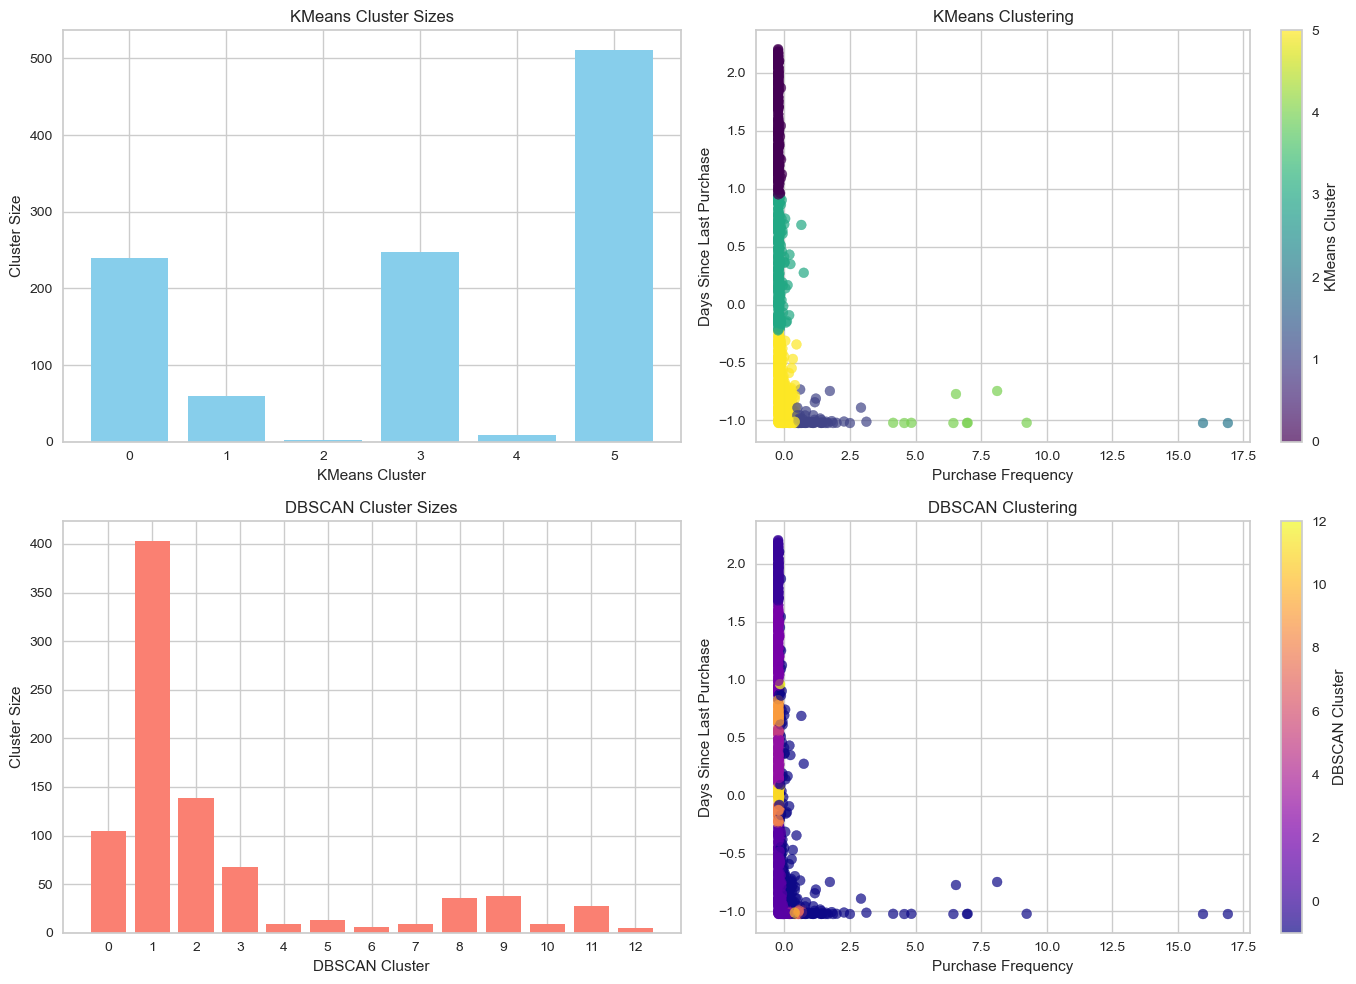

In [452]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `df_final['kmeans_cluster']` contains the KMeans cluster labels
# Assuming `df_final['dbscan_cluster']` contains the DBSCAN cluster labels

# Set up a figure with subplots for histograms and scatter plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Histogram of KMeans Cluster Sizes
unique_kmeans_clusters, kmeans_cluster_counts = np.unique(df_final['kmeans_cluster'], return_counts=True)
axes[0, 0].bar(unique_kmeans_clusters, kmeans_cluster_counts, color='skyblue')
axes[0, 0].set_xlabel('KMeans Cluster')
axes[0, 0].set_ylabel('Cluster Size')
axes[0, 0].set_title('KMeans Cluster Sizes')
axes[0, 0].set_xticks(unique_kmeans_clusters)

# Plot 2: Scatter Plot for KMeans Clusters
scatter_kmeans = axes[0, 1].scatter(
    df_final['purchase_frequency'], 
    df_final['days_since_last_purchase'], 
    c=df_final['kmeans_cluster'], 
    cmap='viridis', 
    s=50, 
    alpha=0.7
)
axes[0, 1].set_xlabel('Purchase Frequency')
axes[0, 1].set_ylabel('Days Since Last Purchase')
axes[0, 1].set_title('KMeans Clustering')
plt.colorbar(scatter_kmeans, ax=axes[0, 1], label='KMeans Cluster')

# Plot 3: Histogram of DBSCAN Cluster Sizes (excluding noise points, labeled as -1)
dbscan_labels = df_final['dbscan_cluster']
dbscan_clusters, dbscan_counts = np.unique(dbscan_labels[dbscan_labels != -1], return_counts=True)  # Exclude noise
axes[1, 0].bar(dbscan_clusters, dbscan_counts, color='salmon')
axes[1, 0].set_xlabel('DBSCAN Cluster')
axes[1, 0].set_ylabel('Cluster Size')
axes[1, 0].set_title('DBSCAN Cluster Sizes')
axes[1, 0].set_xticks(dbscan_clusters)

# Plot 4: Scatter Plot for DBSCAN Clusters
scatter_dbscan = axes[1, 1].scatter(
    df_final['purchase_frequency'], 
    df_final['days_since_last_purchase'], 
    c=dbscan_labels, 
    cmap='plasma', 
    s=50, 
    alpha=0.7
)
axes[1, 1].set_xlabel('Purchase Frequency')
axes[1, 1].set_ylabel('Days Since Last Purchase')
axes[1, 1].set_title('DBSCAN Clustering')
plt.colorbar(scatter_dbscan, ax=axes[1, 1], label='DBSCAN Cluster')

# Adjust layout for readability
plt.tight_layout()
plt.show()


In [453]:
# Calculate the mean for each feature within each cluster
cluster_means = df_final.groupby('kmeans_cluster')[['purchase_frequency', 'days_since_last_purchase']].mean()
print(cluster_means)


                purchase_frequency  days_since_last_purchase
kmeans_cluster                                              
0                        -0.230114                  1.567992
1                         1.079833                 -0.988506
2                        16.441140                 -1.022500
3                        -0.192660                  0.334093
4                         6.428748                 -0.963091
5                        -0.102787                 -0.761546


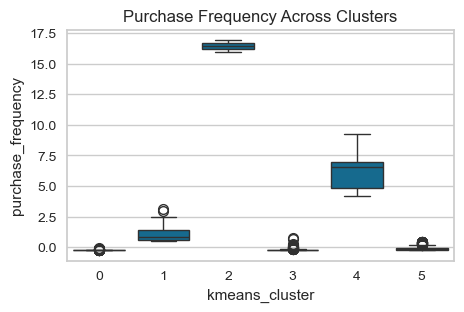

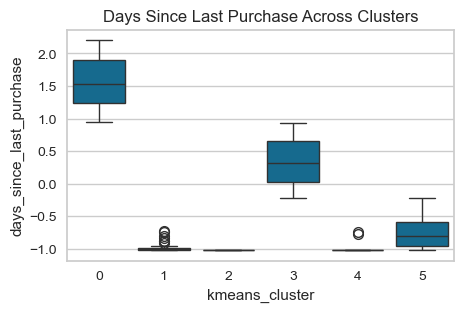

In [454]:
import seaborn as sns

plt.figure(figsize=(5, 3))
sns.boxplot(x='kmeans_cluster', y='purchase_frequency', data=df_final)
plt.title('Purchase Frequency Across Clusters')
plt.show()

plt.figure(figsize=(5, 3))
sns.boxplot(x='kmeans_cluster', y='days_since_last_purchase', data=df_final)
plt.title('Days Since Last Purchase Across Clusters')
plt.show()
